<a href="https://colab.research.google.com/github/DheerajNair/Covid-19-Sentiment-Analysis-using-word-embedding/blob/main/Covid19-Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initial Setup

In [2]:
import torch
import pandas as pd


import os
import io
import codecs
import joblib
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200) 
import string
import tensorflow as tf

from datetime import datetime
from tqdm import notebook
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, concatenate
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D


import warnings 
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
#load data
df = pd.read_csv('/content/drive/MyDrive/finalSentimentdata2.csv')

In [4]:
#preview
df.head()

,Unnamed: 0,sentiment,text
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …
2,654,joy,will nature conservation remain a priority in post corona bangladesh | the daily star
3,2530,sad,"coronavirus disappearing in italy show this to ""intellectuals"" who say lockdowns do not work …"
4,2296,sad,uk records lowest daily virus death toll since start of lockdown govt


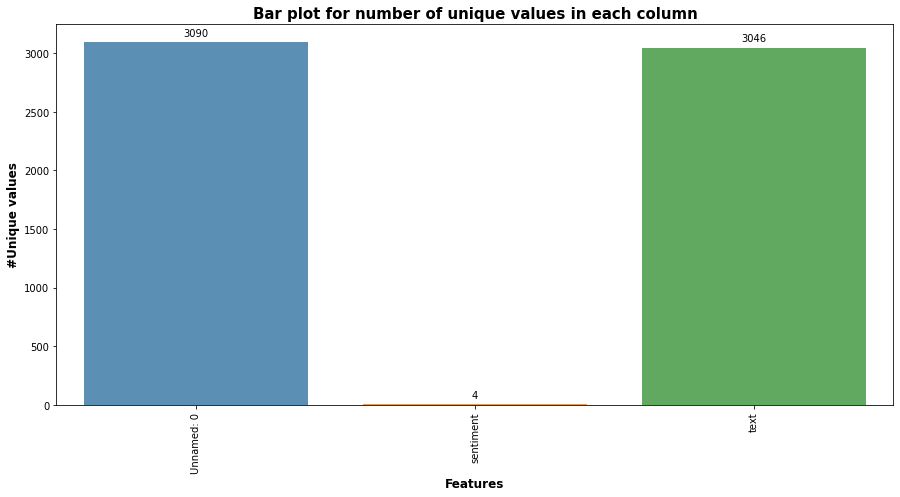

In [5]:
#Unique Values In Each Feature Coulmn

unique_df = pd.DataFrame()
unique_df['Features'] = df.columns
unique=[]
for i in df.columns:
    unique.append(df[i].nunique())
unique_df['Uniques'] = unique

f, ax = plt.subplots(1,1, figsize=(15,7))

splot = sns.barplot(x=unique_df['Features'], y=unique_df['Uniques'], alpha=0.8)
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title('Bar plot for number of unique values in each column',weight='bold', size=15)
plt.ylabel('#Unique values', size=12, weight='bold')
plt.xlabel('Features', size=12, weight='bold')
plt.xticks(rotation=90)
plt.show()

# Feature Set Generation

In [7]:
#Number of characters 
def count_chars(text):
    return len(text)
    print(text)

df['char_count'] = df["text"].apply(lambda x:count_chars(x))


In [8]:
  df['char_count']

0       270
1        93
2        85
3        94
4        69
       ... 
3085    243
3086    101
3087     66
3088    277
3089    100
Name: char_count, Length: 3090, dtype: int64

In [9]:
#Number of words
def count_words(text):
    return len(text.split())

df['word_count'] = df["text"].apply(lambda x:count_words(x))

In [10]:
df['word_count']

0       50
1       20
2       14
3       15
4       12
        ..
3085    46
3086    20
3087    10
3088    51
3089    19
Name: word_count, Length: 3090, dtype: int64

In [11]:
#Number of capital characters
def count_capital_chars(text):
    count=0
    for i in text:
        if i.isupper():
            count+=1
    return count

df['capital_char_count'] = df["text"].apply(lambda x:count_capital_chars(x))

In [12]:
#Number of capital words
def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

df['capital_word_count'] = df["text"].apply(lambda x:count_capital_words(x))

In [13]:
#Count the number of punctuations
def count_punctuations(text):
    punctuations='!"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~'
    d=dict()
    for i in punctuations:
        d[str(i)+' count']=text.count(i)
    return d 

df['punct_count'] = df["text"].apply(lambda x:count_punctuations(x))

In [14]:
#Number of words in quotes
def count_words_in_quotes(text):
    x = re.findall("'.'|\".\"", text)
    count=0
    if x is None:
        return 0
    else:
        for i in x:
            t=i[1:-1]
            count+=count_words(t)
        return count

df['quoted_word_count'] = df["text"].apply(lambda x:count_words_in_quotes(x))

In [15]:
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
#Number of sentences
def count_sent(text):
    return len(nltk.sent_tokenize(text))

df['sent_count'] = df["text"].apply(lambda x:count_sent(x))

In [17]:
#Count the number of unique words
def count_unique_words(text):
    return len(set(text.split()))

df['unique_word_count'] = df["text"].apply(lambda x:count_unique_words(x))

In [18]:
#Count of hashtags
def count_htags(text):
    x = re.findall(r'(#w[A-Za-z0-9]*)', text)
    return len(x) 

df['htag_count'] = df["text"].apply(lambda x:count_htags(x))

In [19]:
#Count of mentions
def count_mentions(text):
    x = re.findall(r'(@w[A-Za-z0-9]*)', text)
    return len(x)

df['mention_count'] = df["text"].apply(lambda x:count_mentions(x))

In [20]:
#Count of stopwords
from nltk.corpus import stopwords
nltk.download('stopwords')

def count_stopwords(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)

df['stopword_count'] = df["text"].apply(lambda x:count_stopwords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [21]:
#Calculating average word length

df['avg_wordlength'] = df['char_count']/df['word_count']

In [22]:
#Calculating average sentence length

df['avg_sentlength'] = df['word_count']/df['sent_count']

In [23]:
#Unique words vs word count feature

df['unique_vs_words'] = df['unique_word_count']/df['word_count']

In [24]:
#Stopwords count vs words counts feature

df['stopwords_vs_words'] = df['stopword_count']/df['word_count']

In [25]:
df.columns

Index(['Unnamed: 0', 'sentiment', 'text', 'char_count', 'word_count',
       'capital_char_count', 'capital_word_count', 'punct_count',
       'quoted_word_count', 'sent_count', 'unique_word_count', 'htag_count',
       'mention_count', 'stopword_count', 'avg_wordlength', 'avg_sentlength',
       'unique_vs_words', 'stopwords_vs_words'],
      dtype='object')

In [26]:
df['sentiment'].value_counts()

fear     801
sad      795
anger    767
joy      727
Name: sentiment, dtype: int64

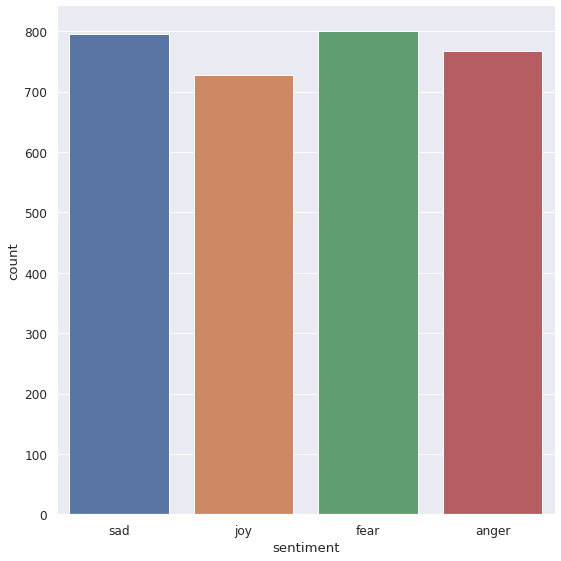

In [27]:
#top sentiments 

sns.set(font_scale=1.1)
sns.catplot("sentiment", data=df, kind="count", height=8)

# Data Preprocessing


In [28]:
#Removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [30]:
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['text'], '@[\w]*')

In [31]:
df.head(2)

,Unnamed: 0,sentiment,text,char_count,word_count,capital_char_count,capital_word_count,punct_count,quoted_word_count,sent_count,unique_word_count,htag_count,mention_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,Tweet
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,270,50,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,39,0,0,18,5.40,50.0,0.78,0.36,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …,93,20,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,19,0,0,8,4.65,20.0,0.95,0.40,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …


In [32]:
#REMOVED HTTP AND URLS FROM TWEET

import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [33]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          3090 non-null   int64  
 1   sentiment           3090 non-null   object 
 2   text                3090 non-null   object 
 3   char_count          3090 non-null   int64  
 4   word_count          3090 non-null   int64  
 5   capital_char_count  3090 non-null   int64  
 6   capital_word_count  3090 non-null   int64  
 7   punct_count         3090 non-null   object 
 8   quoted_word_count   3090 non-null   int64  
 9   sent_count          3090 non-null   int64  
 10  unique_word_count   3090 non-null   int64  
 11  htag_count          3090 non-null   int64  
 12  mention_count       3090 non-null   int64  
 13  stopword_count      3090 non-null   int64  
 14  avg_wordlength      3090 non-null   float64
 15  avg_sentlength      3090 non-null   float64
 16  unique

In [35]:
df.head()

,Unnamed: 0,sentiment,text,char_count,word_count,capital_char_count,capital_word_count,punct_count,quoted_word_count,sent_count,unique_word_count,htag_count,mention_count,stopword_count,avg_wordlength,avg_sentlength,unique_vs_words,stopwords_vs_words,Tweet
0,3204,sad,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,270,50,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,39,0,0,18,5.400000,50.0,0.78,0.360000,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...
1,1431,joy,if only i could have spent the with this cutie vc sakshi__s i n g h coast crossing republik …,93,20,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,19,0,0,8,4.650000,20.0,0.95,0.400000,if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik
2,654,joy,will nature conservation remain a priority in post corona bangladesh | the daily star,85,14,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,14,0,0,4,6.071429,14.0,1.00,0.285714,will nature conservation remain a priority in post corona bangladesh the daily star
3,2530,sad,"coronavirus disappearing in italy show this to ""intellectuals"" who say lockdowns do not work …",94,15,0,0,"{'! count': 0, '"" count': 2, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,15,0,0,6,6.266667,15.0,1.00,0.400000,coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work
4,2296,sad,uk records lowest daily virus death toll since start of lockdown govt,69,12,0,0,"{'! count': 0, '"" count': 0, '# count': 0, '$ count': 0, '% count': 0, '& count': 0, '' count': 0, '( count': 0, ') count': 0, '* count': 0, '+ count': 0, ', count': 0, '- count': 0, '. count': 0,...",0,1,12,0,0,1,5.750000,12.0,1.00,0.083333,uk records lowest daily virus death toll since start of lockdown govt


In [36]:
#move to new dataframe
df_dataset = df[['Tweet','sentiment']]

In [37]:
df_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3090 entries, 0 to 3089
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tweet      3090 non-null   object
 1   sentiment  3090 non-null   object
dtypes: object(2)
memory usage: 48.4+ KB


In [38]:
#store classes into an array
possible_labels = df_dataset.sentiment.unique()
possible_labels

array(['sad', 'joy', 'fear', 'anger'], dtype=object)

In [39]:
#convert labels into numeric values
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [40]:
label_dict

{'anger': 3, 'fear': 2, 'joy': 1, 'sad': 0}

In [41]:
#convert labels into numeric values
df_dataset['label'] = df_dataset.sentiment.replace(label_dict)
df_dataset.head(10)

,Tweet,sentiment,label
0,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,sad,0
1,if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik,joy,1
2,will nature conservation remain a priority in post corona bangladesh the daily star,joy,1
3,coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work,sad,0
4,uk records lowest daily virus death toll since start of lockdown govt,sad,0
5,joe biden s coronavirus web address lands on a donation page for his campaign he is profiting from fear demopos,fear,2
6,respected sir in our telangana all private teachers and lecturers are in horrible situations due to covid and mainly private management chaithanya nd narayana b caz they told to all faculty s like...,sad,0
7,so is also times more lethal than influenza think about that,fear,2
8,thull is passing the most dangerous and ultra hazardous situation in its history population of thul town and surrounding have been striked by corona virus cm health m sindh to take notice we plead...,sad,0
9,thull is passing the most dangerous and ultra hazardous situation in its history population of thul town and surrounding have been striked by corona virus cm health m sindh to take notice we plead...,sad,0


In [42]:
df_dataset.drop(['sentiment'], axis=1, inplace=True)

In [43]:
df_dataset.head()

,Tweet,label
0,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,0
1,if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik,1
2,will nature conservation remain a priority in post corona bangladesh the daily star,1
3,coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work,0
4,uk records lowest daily virus death toll since start of lockdown govt,0


#Load Fasttext vectors


In [44]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
!gzip -d cc.en.300.vec.gz

--2022-01-06 20:01:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325960915 (1.2G) [binary/octet-stream]
Saving to: ‘cc.en.300.vec.gz’

cc.en.300.vec.gz    100%[===================>]   1.23G  22.4MB/s    in 48s     

2022-01-06 20:02:36 (26.2 MB/s) - ‘cc.en.300.vec.gz’ saved [1325960915/1325960915]



In [45]:
#create word vectors
from tqdm import tqdm_notebook

word_vectors = {}
f = io.open("/content/cc.en.300.vec", encoding='utf-8')
n, d = map(int, f.readline().split())
for line in tqdm_notebook(f):
    values = line.rstrip().split(' ')
    word = values[0]
    vector = np.array(values[1:], dtype='float32')
    word_vectors[word] = vector
f.close()
print(f'found {len(word_vectors)} word vectors')

0it [00:00, ?it/s]

found 2000000 word vectors


# Text length distribution

In [46]:
#Finding the text length distribution
df_dataset['sent_len'] = df_dataset['Tweet'].apply(lambda x: len(x.split(" ")))
max_seq_len = np.round(df_dataset['sent_len'].mean() + 2 * df_dataset['sent_len'].std()).astype(int)
max_seq_len

53

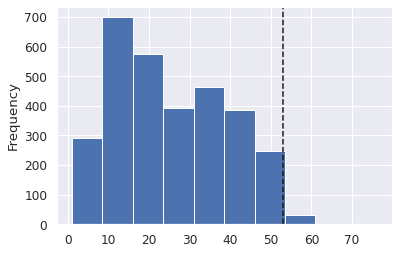

In [47]:
df_dataset['sent_len'].plot.hist()
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len');

# Clean

In [48]:
df_dataset.head()

,Tweet,label,sent_len
0,agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell...,0,49
1,if only i could have spent the with this cutie vc sakshi s i n g h coast crossing republik,1,21
2,will nature conservation remain a priority in post corona bangladesh the daily star,1,13
3,coronavirus disappearing in italy show this to intellectuals who say lockdowns do not work,0,15
4,uk records lowest daily virus death toll since start of lockdown govt,0,12


In [49]:
regex_tokenizer = RegexpTokenizer(r'\w+')

In [50]:
cleaned_text = []

for text in tqdm_notebook(df_dataset['Tweet']):
    tokens = regex_tokenizer.tokenize(text)
    cleaned_text.append(" ".join(tokens))

  0%|          | 0/3090 [00:00<?, ?it/s]

In [51]:
print(cleaned_text[0])

agree the poor in india are treated badly their poors seek a living in singapore and are treated like citizens they are given free medical treatment given food daily sim cards to call home to tell their family that they are fine if covid case treated foc in hospitals


#Tokenize

In [52]:
max_words = 1e5

In [53]:
tokenizer = Tokenizer(num_words=max_words, lower=True, char_level=False)

In [54]:
#tokenize and build dictionary
tokenizer.fit_on_texts(cleaned_text)
input_sequences = tokenizer.texts_to_sequences(cleaned_text)

word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  10085


In [55]:
print(input_sequences[0])

[959, 1, 294, 6, 66, 13, 1188, 1570, 57, 4417, 2273, 7, 521, 6, 1358, 5, 13, 1188, 70, 320, 35, 13, 431, 268, 360, 577, 431, 215, 269, 4418, 4419, 2, 235, 79, 2, 371, 57, 127, 21, 35, 13, 877, 42, 18, 295, 1188, 3035, 6, 396]


# Padding

In [56]:
#pad text to make it of equal length
input_sequences = pad_sequences(input_sequences, maxlen=max_seq_len)

In [57]:
print(input_sequences[0])

[   0    0    0    0  959    1  294    6   66   13 1188 1570   57 4417
 2273    7  521    6 1358    5   13 1188   70  320   35   13  431  268
  360  577  431  215  269 4418 4419    2  235   79    2  371   57  127
   21   35   13  877   42   18  295 1188 3035    6  396]


In [58]:
labels = df_dataset['label'].values

In [59]:
print(labels[36])

1


#Embedding matrix

In [60]:
embed_dim = 300

In [61]:
#creating the embedding matrix
words_not_found = []
nb_words = min(max_words, len(word_index))

embedding_matrix = np.zeros((nb_words+1, embed_dim))

for word, i in word_index.items():
    if i > nb_words:
        break

    vector = word_vectors.get(word)
    if vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = vector
    else:
        words_not_found.append(word)

print('number of null word embeddings: {:d}'.format(np.sum(np.sum(embedding_matrix, axis=1) == 0)))

number of null word embeddings: 1061


In [62]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['khatarnaak' 'tgtwaitingresults' 'erigy' 'modiji' 'avk' 'imdadullah'
 'tejaswini' 'wuflu' 'alvares' 'bollybuzz']


#Train Test Split

In [63]:
#splitting the given dataset into train and test sets
X_train, X_test, y_train, y_test = (
    train_test_split(input_sequences, labels, random_state=42, test_size=0.2)
)

In [64]:
X_train = tf.constant(X_train)
X_test = tf.constant(X_test)

y_train = tf.constant(y_train)
y_test = tf.constant(y_test)

In [65]:
print(f'Train | X shape: {X_train.shape}, y shape: {y_train.shape}')
print(f'Test | X shape: {X_test.shape}, y shape: {y_test.shape}')

Train | X shape: (2472, 53), y shape: (2472,)
Test | X shape: (618, 53), y shape: (618,)


# Create model

In [68]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [69]:
#defining the model
def create_model(input_len):
    inp = Input(shape=(input_len,))

    x = Embedding(nb_words+1, embed_dim,
                  weights=[embedding_matrix],
                  input_length=input_len, trainable=False)(inp)
    
    x1 = Conv1D(200, 3, activation='relu', padding='same')(x)
    x1 = GlobalMaxPooling1D()(x1)

    x2 = Conv1D(200, 4, activation='relu', padding='same')(x)
    x2 = GlobalMaxPooling1D()(x2)

    x3 = Conv1D(200, 5, activation='relu', padding='same')(x)
    x3 = GlobalMaxPooling1D()(x3)

    x = concatenate([x1, x2, x3])
    x = Dropout(0.5)(x)
    x = Dense(30, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(4, activation='softmax')(x)

    model = Model(inputs=inp, outputs=x)

    opt = tf.keras.optimizers.Adam(lr=0.001)

    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy',f1_m,precision_m, recall_m])

    return model

In [70]:
model = create_model(max_seq_len)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 53)]         0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 53, 300)      3025800     ['input_2[0][0]']                
                                                                                                  
 conv1d_3 (Conv1D)              (None, 53, 200)      180200      ['embedding_1[0][0]']            
                                                                                                  
 conv1d_4 (Conv1D)              (None, 53, 200)      240200      ['embedding_1[0][0]']            
                                                                                            

# Training

In [91]:
#metrics for evaluation
loss, metric, f1, prec, rec = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
print(f"Loss before training: {loss:.4f} \nAccuracy before training: {metric:.2%} \nF1 Score: {f1:.4f} \nPrecision: {prec:.4f} \nRecall: {rec:.4f}")

Loss before training: 1.2321 
Accuracy before training: 43.53% 
F1 Score: 3.4853 
Precision: 137000016.0000 
Recall: 1.8176


In [72]:
df_dataset.dtypes

Tweet       object
label        int64
sent_len     int64
dtype: object

In [99]:
#fitting the model
history = model.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
10/10 [==============================] - 9s 889ms/step - loss: 0.2310 - accuracy: 0.9300 - f1_m: 1.0217 - precision_m: 0.9097 - recall_m: 1.1656 - val_loss: 0.8309 - val_accuracy: 0.6796 - val_f1_m: 1.2646 - val_precision_m: 1.1694 - val_recall_m: 1.3788
Epoch 2/20
10/10 [==============================] - 9s 880ms/step - loss: 0.2180 - accuracy: 0.9369 - f1_m: 1.0153 - precision_m: 0.8974 - recall_m: 1.1698 - val_loss: 0.8477 - val_accuracy: 0.6683 - val_f1_m: 1.2487 - val_precision_m: 1.1461 - val_recall_m: 1.3736
Epoch 3/20
10/10 [==============================] - 9s 891ms/step - loss: 0.1989 - accuracy: 0.9393 - f1_m: 0.9967 - precision_m: 0.8796 - recall_m: 1.1509 - val_loss: 0.8575 - val_accuracy: 0.6731 - val_f1_m: 1.2225 - val_precision_m: 1.1155 - val_recall_m: 1.3533
Epoch 4/20
10/10 [==============================] - 9s 873ms/step - loss: 0.1943 - accuracy: 0.9385 - f1_m: 0.9870 - precision_m: 0.8727 - recall_m: 1.1368 - val_loss: 0.8744 - val_accuracy: 0.6683 - va

In [100]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy',f1_m,precision_m, recall_m])


In [101]:
# evaluate the model
#loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)
loss, metric, f1, prec, rec = model.evaluate(X_test, y_test, batch_size=32, verbose=0)

In [102]:
print(f"Loss after training: {loss:.4f} \nAccuracy after training: {metric:.2%} \nF1 Score : {f1:.4f} \nPrecision: {prec:.4f} \nRecall: {rec:.4f}")

Loss after training: 0.9995 
Accuracy after training: 69.09% 
F1 Score : 1.1014 
Precision: 0.9900 
Recall: 1.2488


# Test model on new sentences

In [103]:
def predict(text):
  # pre-process text
    tokens = regex_tokenizer.tokenize(text)
    cleaned_text = [" ".join(tokens)]
    
    input_ = tokenizer.texts_to_sequences(cleaned_text)
    input_ = pad_sequences(input_, maxlen=max_seq_len)
    
    pred = model.predict(input_)[0]

    return pred

In [104]:
label_dict

{'anger': 3, 'fear': 2, 'joy': 1, 'sad': 0}

In [105]:
text = "i am afraid of the virus"

In [106]:
predict(text)

array([0.00293701, 0.00218376, 0.9789525 , 0.01592668], dtype=float32)

In [107]:
result = np.argmax(predict(text), axis=0)
print("Sentiment : ",list(label_dict.keys())[list(label_dict.values()).index(result)])

Sentiment :  fear


In [117]:
text = "I am happy to test negative"

In [118]:
predict(text)

array([0.13466598, 0.44855508, 0.39949462, 0.01728436], dtype=float32)

In [119]:
result = np.argmax(predict(text), axis=0)
print("Sentiment : ",list(label_dict.keys())[list(label_dict.values()).index(result)])

Sentiment :  joy


#Save model

In [120]:
model_save_path = "model.h5"
model.save(model_save_path)

In [121]:
tokenizer_save_path = "tokenizer.joblib"
joblib.dump(tokenizer, tokenizer_save_path)

['tokenizer.joblib']